<a href="https://colab.research.google.com/github/sofia-sunny/SAR/blob/main/SAR_for_off_Target_receptor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identifying Structural Determinants of 5-HT-2B Off-Target Activity**

The **5-HT-2B receptor** is a well-recognized **off-target receptor** due to its association with valvular heart disease. Although not typically the intended target of therapeutic compounds, some molecules may mistakenly bind to and activate 5-HT-2B. Because of this risk, such off-target activity has been linked to serious cardiotoxic outcomes, including valve thickening and dysfunction. As a result, 5-HT-2B activation is carefully monitored and evaluated throughout the drug development process to minimize potential safety concerns.

Due to the safety risks associated with off-target 5-HT-2B receptor activation, **we aim to identify structural features that reduce 5-HT-2B binding affinity**. We explore bioactivity data from the ChEMBL database, focusing on congeneric series—sets of structurally related compounds—with varying levels of 5-HT-2B activity. Our approach involves identifying **common scaffolds** within these series to enable meaningful **structure–activity relationship (SAR) analysis**.

### By comparing the structural interactions of active vs. inactive compounds, we can:

* **Understand what structural features drive 5-HT-2B binding.**

* **Design safer compounds by avoiding those features.**

* **Use structure-guided insights to reduce off-target activity while preserving efficacy at the intended target.**



In [19]:
import sys, subprocess
if "google.colab" in sys.modules:
  print("Running in Google Colab...")
  from IPython.utils import io
  print("In Google Colab...Installing packages...")
  with io.capture_output():
    subprocess.run(
        ['pip', 'install','ipywidgets','tqdm','useful_rdkit_utils']
    )
  print('completed')

Running in Google Colab...
In Google Colab...Installing packages...
completed


importing necessary programs:

In [20]:
import pandas as pd
from tqdm.auto import tqdm
import useful_rdkit_utils as uru
from rdkit.Chem import rdFMCS, Draw
import numpy as np
from rdkit import Chem
from ipywidgets import interact, IntSlider, Dropdown, VBox, HTML

**tqdm.pandas()** enables progress bars for pandas functions such as apply()

In [21]:
tqdm.pandas()

Get a subset of cleaned ChEMBL bioactivity data for the 5-HT2B receptor

In [22]:
url = "https://raw.githubusercontent.com/sofia-sunny/SAR/main/chembl_5ht2b_activity.csv"
df = pd.read_csv(url, sep=";")
df.head()

,doc_id,doi,title,assay_id,compound_key,molregno,canonical_smiles,standard_type,standard_value,standard_relation,standard_units,pchembl_value
0,1883,10.1016/S0960-894X(96)00503-3,Some benzenesulfonamido-substituted valerophen...,2889,16,146359,COc1cc(OC)c(C(=O)CCCCN2CCC3(CC2)NC(=O)NC3=O)cc...,Ki,199.530,=,nM,6.7
1,1883,10.1016/S0960-894X(96)00503-3,Some benzenesulfonamido-substituted valerophen...,2889,Mesulergine,10959,CN1C[C@@H](NS(=O)(=O)N(C)C)C[C@@H]2c3cccc4c3c(...,Ki,1.995,=,nM,8.7
2,1883,10.1016/S0960-894X(96)00503-3,Some benzenesulfonamido-substituted valerophen...,2889,28,146400,COc1cc(OC)c(C(=O)CCCCN2CCC3(CC2)NC(=O)NC3=O)cc...,Ki,398.110,=,nM,6.4
3,1883,10.1016/S0960-894X(96)00503-3,Some benzenesulfonamido-substituted valerophen...,2889,8,146461,COc1ccc(-c2ccccc2)cc1C(=O)CCCCN1CCC2(CC1)NC(=O...,Ki,10.000,=,nM,8.0
4,1883,10.1016/S0960-894X(96)00503-3,Some benzenesulfonamido-substituted valerophen...,2889,26,146851,COc1cc(OC)c(C(=O)CCCCN2CCC3(CC2)NC(=O)NC3=O)cc...,Ki,316.230,=,nM,6.5


**Remember:**

In ChEMBL, **standard_value** is the measured bioactivity expressed in a consistent unit, usually nanomolar (**nM**).

**pchembl_value** takes that value, converts it to molar units, and then expresses it on a logarithmic scale.
For example, a compound’s standard_value = 1000 nM  becomes a pchembl_value of 6.0.

## **Extract Congeneric Series by Scaffold and Assay**
**(The functions in this section are adapted from [Pat Walters’s tutorial “Searching the ChEMBL Database for Interesting SAR”](https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/misc/ChEMBL_hERG_series.ipynb))**

The **get_series_from_paper function** below processes the molecular structures from a paper and identifies congeneric series—sets of structurally related compounds with varying activity.

This function returns **a list of scaffold–series pairs**, where each item is a list containing two elements: the **SMILES string of a core scaffold** and a **DataFrame of molecules that share this scaffold**. These molecules are all part of the same assay. Each DataFrame in the list represents a potential congeneric series—structurally related compounds tested under consistent experimental conditions—making the output suitable for exploring structure–activity relationships

In [23]:
def get_series_from_paper(input_df):
    res = []
    for k,v in input_df.groupby(["assay_id","standard_type","standard_units"]):
        paper_df = v.copy()
        paper_df['mol'] = paper_df.canonical_smiles.apply(Chem.MolFromSmiles)
        activity_df = paper_df[['doc_id','doi','canonical_smiles','molregno','compound_key','standard_value','assay_id','standard_type','standard_units','pchembl_value']]
        mol_df, scaffold_df = uru.find_scaffolds(paper_df,smiles_col="canonical_smiles",name_col="molregno", disable_progress=True)
        scaffold_smi, out_df = uru.get_molecules_with_scaffold(scaffold_df.Scaffold.values[0], mol_df, activity_df,
                                  smiles_col="canonical_smiles",
                                  name_col="molregno",
                                  activity_col="standard_value",
                                  extra_cols=["compound_key","assay_id","standard_type","standard_units","doc_id","pchembl_value"])
        out_df.merge(paper_df[["canonical_smiles","molregno","compound_key"]],on=["canonical_smiles","molregno"])
        if len(out_df) > 1:
            res.append([scaffold_smi,out_df])
    return res

We can check one of these scaffold–series pairs, where **each scaffold and its related molecules**—along with their bioactivity data—are stored together in a list.

In [24]:
test_df = df.query("doc_id == 99511")
test_res = get_series_from_paper(test_df)
test_res[0]

[array(['COc1ccc(CCN(CCCc2ccc([*:1])c([*:2])c2[*:3])CCc2ccc3c(c2)OCO3)cc1OC'],
       dtype=object),
                                      canonical_smiles  molregno  \
 0     COc1ccc(CCN(CCCc2ccccc2)CCc2ccc3c(c2)OCO3)cc1OC   2050779   
 1   COc1ccc(CCN(CCCc2ccc(F)cc2)CCc2ccc3c(c2)OCO3)c...   2089989   
 2   COc1ccc(CCN(CCCc2ccc(Cl)cc2)CCc2ccc3c(c2)OCO3)...   2089990   
 3   COc1ccc(CCN(CCCc2ccc(Br)cc2)CCc2ccc3c(c2)OCO3)...   2089991   
 4   COc1ccc(CCN(CCCc2ccc(I)cc2)CCc2ccc3c(c2)OCO3)c...   2089992   
 5   COc1ccc(CCN(CCCc2cccc(F)c2)CCc2ccc3c(c2)OCO3)c...   2089993   
 6   COc1ccc(CCN(CCCc2cccc(Cl)c2)CCc2ccc3c(c2)OCO3)...   2089994   
 7   COc1ccc(CCN(CCCc2cccc(Br)c2)CCc2ccc3c(c2)OCO3)...   2089995   
 8   COc1ccc(CCN(CCCc2cccc(I)c2)CCc2ccc3c(c2)OCO3)c...   2089996   
 9    COc1ccc(CCN(CCCc2ccccc2F)CCc2ccc3c(c2)OCO3)cc1OC   2089997   
 10  COc1ccc(CCN(CCCc2ccccc2Cl)CCc2ccc3c(c2)OCO3)cc1OC   2089998   
 11  COc1ccc(CCN(CCCc2ccccc2Br)CCc2ccc3c(c2)OCO3)cc1OC   2089999   
 12   COc1ccc(C

In the following code, for each doc_id with more than two compounds, the **get_series_from_paper** function is called, returning one or more scaffold–series (each as [scaffold_smi, paper_df]).

For each series, the rows are stamped with the paper’s DOI and the scaffold SMILES (taken from the first element of scaffold_smi), duplicates are removed, and the resulting tidy DataFrame is appended to df_list.

In [25]:
df_list = []
for k,v in tqdm(df.groupby("doc_id")):
    if len(v) > 2:
        series_res = get_series_from_paper(v)
        for scaffold_smi, paper_df in series_res:
            if len(scaffold_smi):
                paper_df.loc[:,'doi'] = v.doi.values[0]
                paper_df.loc[:,'scaffold'] = scaffold_smi[0]
                paper_df.drop_duplicates(["canonical_smiles","molregno"],inplace=True)
                df_list.append(paper_df)

  0%|          | 0/280 [00:00<?, ?it/s]

Let’s check one of these DataFrames using **uru.align_mols_to_template** function which aligns the set of molecules to a template (scaffold) so they share the same 2D layout around the common substructure.

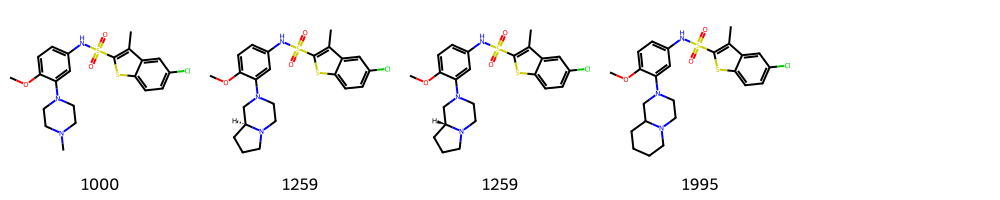

In [ ]:
sample_df = df_list[4].copy()
sample_df.sort_values("standard_value",inplace=True)
legends = [f"{x:.0f}" for x in sample_df.standard_value]
Chem.Draw.MolsToGridImage(uru.align_mols_to_template(sample_df.scaffold.values[0],sample_df.canonical_smiles),molsPerRow=5,useSVG=True,legends=legends)

Save all DataFrames in df_list to a CSV file:

In [ ]:
pd.concat(df_list).to_csv("chembl_5ht2b_summary.csv",index=False)

Put all DataFrames in a single all_df

In [ ]:
all_df = pd.concat(df_list)
all_df.head()

,canonical_smiles,molregno,standard_value,compound_key,assay_id,standard_type,standard_units,doc_id,pchembl_value,doi,scaffold
0,COc1cc(OC)c(C(=O)CCCCN2CCC3(CC2)NC(=O)NC3=O)cc...,146359,199.53,16,2889,Ki,nM,1883,6.7,10.1016/S0960-894X(96)00503-3,COc1cc([*:2])c([*:1])cc1C(=O)CCCCN1CCC2(CC1)NC...
1,COc1cc(OC)c(C(=O)CCCCN2CCC3(CC2)NC(=O)NC3=O)cc...,146400,398.11,28,2889,Ki,nM,1883,6.4,10.1016/S0960-894X(96)00503-3,COc1cc([*:2])c([*:1])cc1C(=O)CCCCN1CCC2(CC1)NC...
2,COc1ccc(-c2ccccc2)cc1C(=O)CCCCN1CCC2(CC1)NC(=O...,146461,10.00,8,2889,Ki,nM,1883,8.0,10.1016/S0960-894X(96)00503-3,COc1cc([*:2])c([*:1])cc1C(=O)CCCCN1CCC2(CC1)NC...
3,COc1cc(OC)c(C(=O)CCCCN2CCC3(CC2)NC(=O)NC3=O)cc...,146779,125.89,20,2889,Ki,nM,1883,6.9,10.1016/S0960-894X(96)00503-3,COc1cc([*:2])c([*:1])cc1C(=O)CCCCN1CCC2(CC1)NC...
4,COc1cc(OC)c(C(=O)CCCCN2CCC3(CC2)NC(=O)NC3=O)cc...,146874,316.23,21,2889,Ki,nM,1883,6.5,10.1016/S0960-894X(96)00503-3,COc1cc([*:2])c([*:1])cc1C(=O)CCCCN1CCC2(CC1)NC...


We can examine the scaffold counts for each group. For example, the first scaffold **(COc1cc([*:2])c([*:1])cc1C(=O)CCCCN1CCC2(CC1)NC(=O)NC2=O)**  occurs in 16 molecules, the second in 29 molecules, and so on.

In [ ]:
all_df.scaffold.value_counts(sort=False).head()

,count
scaffold,
COc1cc([*:2])c([*:1])cc1C(=O)CCCCN1CCC2(CC1)NC(=O)NC2=O,16
O=C(Nc1cnc(Oc2cccnc2C[*:6])c([*:5])c1[*:4])N1CCc2c1cc([*:1])c([*:2])c2[*:3],29
O=C(Nc1ccc(OC[*:4])nc1)N1CCc2c1cc([*:1])c([*:2])c2[*:3],16
O=C(Nc1ccc([*:1])c([*:2])c1)Nc1ccnc2ccccc12,4
COc1ccc(NS(=O)(=O)c2sc3ccc(Cl)cc3c2C)cc1[*:1],4


## **MMP Cliffs: Identifying Key Structural Features That Control Potency**
A Matched Molecular Pair (**MMP**) is a pair of molecules that are structurally identical except for a small, well-defined change at a single site. When two such molecules have nearly identical scaffolds but show a large difference in biological activity (e.g., pChEMBL values), they form what is known as an **MMP cliff**. This sharp activity shift suggests that the specific chemical change is directly responsible for the difference in potency.

By analyzing MMP cliffs, we can pinpoint the exact functional group or atom that enhances or diminishes activity, providing clear guidance for analog design. This enables the creation of a **“transformation playbook”**, highlighting impactful substitutions such as:

* Adding a methyl group to position X → increases potency

* Replacing an ether with an amide → reduces potency

In addition, MMP cliffs often uncover some surprising SAR features that aren't obvious from raw dat

In [ ]:
all_df['mol'] = all_df['canonical_smiles'].apply(Chem.MolFromSmiles)
mmp_cliffs = []
for scaffold, group in tqdm(all_df.groupby("scaffold")):
    group = group.reset_index(drop=True)
    if len(group) < 2:
        continue
    max_delta, best_pair = -1, None
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            type1 = group.loc[i, 'standard_type']
            type2 = group.loc[j, 'standard_type']
            if type1 != type2:
                continue
            val1, val2 = group.loc[i, 'pchembl_value'], group.loc[j, 'pchembl_value']
            if val1 > 0 and val2 > 0:
                delta = abs(val1- val2)
                if delta > max_delta:
                    max_delta, best_pair = delta, (i, j)

    if best_pair and max_delta >= 1:
        i, j = best_pair
        row1, row2 = group.loc[i], group.loc[j]
        mol1, mol2 = row1['mol'], row2['mol']
        if mol1 and mol2:
            mcs = rdFMCS.FindMCS([mol1, mol2], completeRingsOnly=True, ringMatchesRingOnly=True, timeout=10)
            if not mcs.canceled and mcs.numAtoms >= 5:
                mmp_cliffs.append({
                    "molregno_1": row1['molregno'],
                    "molregno_2": row2['molregno'],
                    "canonical_smiles_1": row1['canonical_smiles'],
                    "canonical_smiles_2": row2['canonical_smiles'],
                    "pchembl_valuee_1": row1['pchembl_value'],
                    "pchembl_value_2": row2['pchembl_value'],
                    "delta_pchembl_value": round(max_delta, 1),
                    "scaffold": scaffold,
                    "standard_type": row1['standard_type'],
                    "mcs_smarts": mcs.smartsString
                })

mmp_df = pd.DataFrame(mmp_cliffs)

  0%|          | 0/170 [00:00<?, ?it/s]

In [ ]:
mmp_df.head()

,molregno_1,molregno_2,canonical_smiles_1,canonical_smiles_2,pchembl_valuee_1,pchembl_value_2,delta_pchembl_value,scaffold,standard_type,mcs_smarts
0,688991,689132,CC(C)(CN1CCN(C2=Cc3ccccc3Cn3ccnc32)CC1)C(=O)O,Cc1nc2n(c1C)Cc1ccccc1C=C2N1CCN(CC(C)(C)C(=O)O)CC1,5.80,7.80,2.0,C1=C(N2CC([*:3])N([*:4])C([*:5])C2)c2nc([*:2])...,Ki,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R]-&!...
1,2597903,2856968,C1=CC2(CCNCC2)Oc2ccccc21,Clc1cccc2c1C=CC1(CCNCC1)O2,6.00,7.20,1.2,C1=CC2(CCNCC2)Oc2c([*:2])ccc([*:1])c21,EC50,[#6]1=&@[#6]-&@[#6]2(-&@[#6]-&@[#6]-&@[#7]-&@[...
2,2137759,2165507,Fc1ccc2c(c1Cl)N1CCNCC1CC2,c1ccc(Oc2cccc3c2CCC2CNCCN32)cc1,8.70,5.20,3.5,C1CN2c3c(c([*:2])c([*:5])c([*:4])c3[*:3])CC([*...,EC50,[#6]1:&@[#6]:&@[#6]:&@[#6]2:&@[#6](:&@[#6]:&@1...
3,301184,301257,COc1cc2c(cc1Br)[C@H](C)CNCC2,COc1ccc2c(c1)C(C)CNCC2,7.52,5.30,2.2,C1Cc2c(c([*:2])c([*:5])c([*:4])c2[*:3])C([*:1]...,EC50,[#6&!R]-&!@[#8&!R]-&!@[#6]1:&@[#6]:&@[#6]:&@[#...
4,2240127,2221158,CCn1nc(-c2cccc3cccnc23)cc1-c1cccnn1,CCn1nc(-c2cccc3cccnc23)cc1-c1ccc(N)nn1,8.52,7.32,1.2,CCn1nc(-c2cccc3cccnc23)cc1-c1ccc([*:1])nn1,EC50,[#6&!R]-&!@[#6&!R]-&!@[#7]1:&@[#7]:&@[#6](:&@[...


In [27]:
# --- helper: bond indices within a matched atom set ---
def _bonds_from_atoms(mol, atom_idx_tuple):
    s = set(atom_idx_tuple)
    return [b.GetIdx() for b in mol.GetBonds()
            if b.GetBeginAtomIdx() in s and b.GetEndAtomIdx() in s]

def _fmt_num(x):
    try:
        return f"{float(x):.1f}"
    except Exception:
        return "NA"

def view_pair(idx: int, highlight="MCS"):
    row = mmp_df.iloc[int(idx)]

    mol1 = Chem.MolFromSmiles(row["canonical_smiles_1"])
    mol2 = Chem.MolFromSmiles(row["canonical_smiles_2"])

    # Pattern to highlight (MCS or scaffold)
    patt_sma = row["mcs_smarts"] if highlight == "MCS" else row["scaffold"]
    patt = Chem.MolFromSmarts(patt_sma) if isinstance(patt_sma, str) and len(patt_sma) else None

    match1 = mol1.GetSubstructMatch(patt) if (patt and mol1 and mol1.HasSubstructMatch(patt)) else ()
    match2 = mol2.GetSubstructMatch(patt) if (patt and mol2 and mol2.HasSubstructMatch(patt)) else ()
    bonds1 = _bonds_from_atoms(mol1, match1) if match1 else []
    bonds2 = _bonds_from_atoms(mol2, match2) if match2 else []

    # header info
    info = HTML(
        value=(
            f"<b>Standard type:</b> {row.get('standard_type','')}"
            f"&nbsp;&nbsp;|&nbsp;&nbsp;<b>Δ pChEMBL:</b> {_fmt_num(row.get('delta_pchembl_value'))}"
        )
    )

    p1 = _fmt_num(row.get("pchembl_valuee_1"))  # <- your column as given
    p2 = _fmt_num(row.get("pchembl_value_2"))

    svg = Draw.MolsToGridImage(
        [mol1, mol2],
        molsPerRow=2,
        subImgSize=(360, 360),
        useSVG=True,
        highlightAtomLists=[match1, match2],
        highlightBondLists=[bonds1, bonds2],
        legends=[f"pChEMBL: {p1}", f"pChEMBL: {p2}"]
    )

    svg_str = getattr(svg, "data", svg)
    return VBox([info, HTML(value=svg_str)])

interact(
    view_pair,
    idx=IntSlider(min=0, max=len(mmp_df)-1, step=1, value=0, description="Row"),
    highlight=Dropdown(options=["MCS","Scaffold"], value="MCS", description="Highlight")
);


interactive(children=(IntSlider(value=0, description='Row', max=87), Dropdown(description='Highlight', options…

This striking example reveals a 2-unit difference in pChEMBL values—equating to a 100-fold change in Kᵢ standard values (1,584.89 nM vs. 15.85 nM)—between two closely related compounds, underscoring how even minor structural modifications can dramatically influence binding affinity. A high Kᵢ standard value (and low pChEMBL) reflects weak binding, which is preferred for off-targets to minimize unwanted interactions and potential side effects